## Import libraries and download data

In [26]:
import os

import numpy as np

import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torch import device
import torch.nn as nn
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torchsummary import summary

import matplotlib.pyplot as plt

from tensorflow import io
from tensorflow import image

In [ ]:
# cuda or gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# import dataset from kaggle
!mkdir /root/.kaggle
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle datasets download -d spandan2/cats-faces-64x64-for-generative-models

cats-faces-64x64-for-generative-models.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip -qq cats-faces-64x64-for-generative-models.zip -d /content/

In [ ]:
# images to tensor
image_size = 64
batch_size = 128
latent_size= 64
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train = ImageFolder('/content/cats', transform=tt.Compose([tt.Resize(image_size),
                                                  tt.ToTensor(),
                                                  tt.Normalize(*stats)]))
 
train_dl = DataLoader(train, batch_size, shuffle=True, pin_memory=True) 

## Create generator

In [ ]:
generator = nn.Sequential(
    
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # 3 x 64 x 64
)

## Create discriminator

In [ ]:
discriminator = nn.Sequential(
    # 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=True),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=True),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=True),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # 512 x 4 x 4

    nn.Conv2d(512, 64 , kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(64, 1 , kernel_size=1, stride=1, padding=0, bias=False),

    # 1 x 1 x 1

    nn.Flatten(),
    nn.Linear(1,1))

In [ ]:
summary(discriminator.to(device), (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,136
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         LeakyReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 16, 16]         131,200
       BatchNorm2d-5          [-1, 128, 16, 16]             256
         LeakyReLU-6          [-1, 128, 16, 16]               0
            Conv2d-7            [-1, 256, 8, 8]         524,544
       BatchNorm2d-8            [-1, 256, 8, 8]             512
         LeakyReLU-9            [-1, 256, 8, 8]               0
           Conv2d-10            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-11            [-1, 512, 4, 4]           1,024
        LeakyReLU-12            [-1, 512, 4, 4]               0
           Conv2d-13             [-1, 64, 1, 1]         524,288
      BatchNorm2d-14             [-1, 6

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
sample_dir = 'generated_WG'
os.makedirs(sample_dir, exist_ok=True)

def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors).to(device)
    fake_fname = 'image-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
def train_discriminator(real_images, opt_d):
    opt_d.zero_grad()
    real_preds = discriminator(real_images).to(device) 
    real_targets = -1* torch.ones(real_images.size(0), 1).to(device) 
    real_loss = torch.mean(real_preds) 
    real_score = torch.mean(real_preds).item()
    latent = torch.randn(batch_size, latent_size, 1, 1).to(device) 
    fake_images = generator(latent).to(device)  
    fake_targets = torch.ones(fake_images.size(0), 1).to(device) 
    fake_preds = discriminator(fake_images).to(device)  
    fake_loss = -torch.mean(fake_preds)  
    fake_score = torch.mean(fake_preds).item()
    loss = torch.mean(real_loss + fake_loss)
    loss.backward()
    opt_d.step()

    for p in discriminator.parameters():
      p.data.clamp_(-0.01, 0.01) 

    return loss.item(), real_score, fake_score

In [ ]:
def train_generator(opt_g):
    opt_g.zero_grad()
    latent = torch.randn(batch_size, latent_size, 1,1).to(device) 
    fake_images = generator(latent).to(device) 
    preds = discriminator(fake_images).to(device) 
    targets = -1*torch.ones(batch_size, 1).to(device)
    loss = torch.mean(preds) 
    loss.backward()
    opt_g.step()
    
    return loss.item(),latent

## Training

In [ ]:
def fit(epochs=200, lr=0.0002, start_idx=1):
    torch.cuda.empty_cache()
    
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
  
    opt_d = torch.optim.RMSprop(discriminator.to(device).parameters(), lr=lr)
    opt_g = torch.optim.RMSprop(generator.to(device).parameters(), lr=lr)
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            
            real_images = real_images.to(device)
            for i in range(5):
              loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            
            loss_g, latent = train_generator(opt_g)

            
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        print(f"[{epoch+1}/{epochs}], loss_g: {loss_g:.4f}, loss_d: {loss_g:.4f}, real_score: {real_score:.4f}, fake_score: {fake_score:.4f}")
    
        save_samples(epoch+start_idx, latent, show=False)
    
    return losses_g, losses_d, latent, fake_scores

In [ ]:
loss_g, loss_d, latent, fake_scores = fit()

  0%|          | 0/124 [00:00<?, ?it/s]

[1/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0001.png


  0%|          | 0/124 [00:00<?, ?it/s]

[2/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0002.png


  0%|          | 0/124 [00:00<?, ?it/s]

[3/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0003.png


  0%|          | 0/124 [00:00<?, ?it/s]

[4/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0004.png


  0%|          | 0/124 [00:00<?, ?it/s]

[5/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0005.png


  0%|          | 0/124 [00:00<?, ?it/s]

[6/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0006.png


  0%|          | 0/124 [00:00<?, ?it/s]

[7/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0007.png


  0%|          | 0/124 [00:00<?, ?it/s]

[8/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0008.png


  0%|          | 0/124 [00:00<?, ?it/s]

[9/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0009.png


  0%|          | 0/124 [00:00<?, ?it/s]

[10/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0010.png


  0%|          | 0/124 [00:00<?, ?it/s]

[11/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0011.png


  0%|          | 0/124 [00:00<?, ?it/s]

[12/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0012.png


  0%|          | 0/124 [00:00<?, ?it/s]

[13/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0013.png


  0%|          | 0/124 [00:00<?, ?it/s]

[14/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0014.png


  0%|          | 0/124 [00:00<?, ?it/s]

[15/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0015.png


  0%|          | 0/124 [00:00<?, ?it/s]

[16/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0016.png


  0%|          | 0/124 [00:00<?, ?it/s]

[17/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0017.png


  0%|          | 0/124 [00:00<?, ?it/s]

[18/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0018.png


  0%|          | 0/124 [00:00<?, ?it/s]

[19/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0019.png


  0%|          | 0/124 [00:00<?, ?it/s]

[20/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0020.png


  0%|          | 0/124 [00:00<?, ?it/s]

[21/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0021.png


  0%|          | 0/124 [00:00<?, ?it/s]

[22/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0022.png


  0%|          | 0/124 [00:00<?, ?it/s]

[23/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0023.png


  0%|          | 0/124 [00:00<?, ?it/s]

[24/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0024.png


  0%|          | 0/124 [00:00<?, ?it/s]

[25/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0025.png


  0%|          | 0/124 [00:00<?, ?it/s]

[26/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0026.png


  0%|          | 0/124 [00:00<?, ?it/s]

[27/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0027.png


  0%|          | 0/124 [00:00<?, ?it/s]

[28/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0028.png


  0%|          | 0/124 [00:00<?, ?it/s]

[29/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0029.png


  0%|          | 0/124 [00:00<?, ?it/s]

[30/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0030.png


  0%|          | 0/124 [00:00<?, ?it/s]

[31/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0031.png


  0%|          | 0/124 [00:00<?, ?it/s]

[32/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0032.png


  0%|          | 0/124 [00:00<?, ?it/s]

[33/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0033.png


  0%|          | 0/124 [00:00<?, ?it/s]

[34/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0034.png


  0%|          | 0/124 [00:00<?, ?it/s]

[35/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0035.png


  0%|          | 0/124 [00:00<?, ?it/s]

[36/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0036.png


  0%|          | 0/124 [00:00<?, ?it/s]

[37/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0037.png


  0%|          | 0/124 [00:00<?, ?it/s]

[38/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0038.png


  0%|          | 0/124 [00:00<?, ?it/s]

[39/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0039.png


  0%|          | 0/124 [00:00<?, ?it/s]

[40/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0040.png


  0%|          | 0/124 [00:00<?, ?it/s]

[41/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0041.png


  0%|          | 0/124 [00:00<?, ?it/s]

[42/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0042.png


  0%|          | 0/124 [00:00<?, ?it/s]

[43/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0043.png


  0%|          | 0/124 [00:00<?, ?it/s]

[44/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0044.png


  0%|          | 0/124 [00:00<?, ?it/s]

[45/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0045.png


  0%|          | 0/124 [00:00<?, ?it/s]

[46/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0046.png


  0%|          | 0/124 [00:00<?, ?it/s]

[47/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0047.png


  0%|          | 0/124 [00:00<?, ?it/s]

[48/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0048.png


  0%|          | 0/124 [00:00<?, ?it/s]

[49/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0049.png


  0%|          | 0/124 [00:00<?, ?it/s]

[50/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0050.png


  0%|          | 0/124 [00:00<?, ?it/s]

[51/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0051.png


  0%|          | 0/124 [00:00<?, ?it/s]

[52/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0052.png


  0%|          | 0/124 [00:00<?, ?it/s]

[53/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0053.png


  0%|          | 0/124 [00:00<?, ?it/s]

[54/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0054.png


  0%|          | 0/124 [00:00<?, ?it/s]

[55/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0055.png


  0%|          | 0/124 [00:00<?, ?it/s]

[56/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0056.png


  0%|          | 0/124 [00:00<?, ?it/s]

[57/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0057.png


  0%|          | 0/124 [00:00<?, ?it/s]

[58/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0058.png


  0%|          | 0/124 [00:00<?, ?it/s]

[59/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0059.png


  0%|          | 0/124 [00:00<?, ?it/s]

[60/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0060.png


  0%|          | 0/124 [00:00<?, ?it/s]

[61/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0061.png


  0%|          | 0/124 [00:00<?, ?it/s]

[62/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0062.png


  0%|          | 0/124 [00:00<?, ?it/s]

[63/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0063.png


  0%|          | 0/124 [00:00<?, ?it/s]

[64/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0064.png


  0%|          | 0/124 [00:00<?, ?it/s]

[65/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0065.png


  0%|          | 0/124 [00:00<?, ?it/s]

[66/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0066.png


  0%|          | 0/124 [00:00<?, ?it/s]

[67/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0067.png


  0%|          | 0/124 [00:00<?, ?it/s]

[68/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0068.png


  0%|          | 0/124 [00:00<?, ?it/s]

[69/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0069.png


  0%|          | 0/124 [00:00<?, ?it/s]

[70/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0070.png


  0%|          | 0/124 [00:00<?, ?it/s]

[71/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0071.png


  0%|          | 0/124 [00:00<?, ?it/s]

[72/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0072.png


  0%|          | 0/124 [00:00<?, ?it/s]

[73/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0073.png


  0%|          | 0/124 [00:00<?, ?it/s]

[74/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0074.png


  0%|          | 0/124 [00:00<?, ?it/s]

[75/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0075.png


  0%|          | 0/124 [00:00<?, ?it/s]

[76/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0076.png


  0%|          | 0/124 [00:00<?, ?it/s]

[77/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0077.png


  0%|          | 0/124 [00:00<?, ?it/s]

[78/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0078.png


  0%|          | 0/124 [00:00<?, ?it/s]

[79/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0079.png


  0%|          | 0/124 [00:00<?, ?it/s]

[80/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0080.png


  0%|          | 0/124 [00:00<?, ?it/s]

[81/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0081.png


  0%|          | 0/124 [00:00<?, ?it/s]

[82/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0082.png


  0%|          | 0/124 [00:00<?, ?it/s]

[83/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0083.png


  0%|          | 0/124 [00:00<?, ?it/s]

[84/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0084.png


  0%|          | 0/124 [00:00<?, ?it/s]

[85/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0085.png


  0%|          | 0/124 [00:00<?, ?it/s]

[86/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0086.png


  0%|          | 0/124 [00:00<?, ?it/s]

[87/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0087.png


  0%|          | 0/124 [00:00<?, ?it/s]

[88/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0088.png


  0%|          | 0/124 [00:00<?, ?it/s]

[89/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0089.png


  0%|          | 0/124 [00:00<?, ?it/s]

[90/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0090.png


  0%|          | 0/124 [00:00<?, ?it/s]

[91/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0091.png


  0%|          | 0/124 [00:00<?, ?it/s]

[92/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0092.png


  0%|          | 0/124 [00:00<?, ?it/s]

[93/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0093.png


  0%|          | 0/124 [00:00<?, ?it/s]

[94/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0094.png


  0%|          | 0/124 [00:00<?, ?it/s]

[95/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0095.png


  0%|          | 0/124 [00:00<?, ?it/s]

[96/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0096.png


  0%|          | 0/124 [00:00<?, ?it/s]

[97/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0097.png


  0%|          | 0/124 [00:00<?, ?it/s]

[98/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0098.png


  0%|          | 0/124 [00:00<?, ?it/s]

[99/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0099.png


  0%|          | 0/124 [00:00<?, ?it/s]

[100/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0100.png


  0%|          | 0/124 [00:00<?, ?it/s]

[101/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0101.png


  0%|          | 0/124 [00:00<?, ?it/s]

[102/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0102.png


  0%|          | 0/124 [00:00<?, ?it/s]

[103/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0103.png


  0%|          | 0/124 [00:00<?, ?it/s]

[104/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0104.png


  0%|          | 0/124 [00:00<?, ?it/s]

[105/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0105.png


  0%|          | 0/124 [00:00<?, ?it/s]

[106/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0106.png


  0%|          | 0/124 [00:00<?, ?it/s]

[107/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0107.png


  0%|          | 0/124 [00:00<?, ?it/s]

[108/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0108.png


  0%|          | 0/124 [00:00<?, ?it/s]

[109/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0109.png


  0%|          | 0/124 [00:00<?, ?it/s]

[110/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0110.png


  0%|          | 0/124 [00:00<?, ?it/s]

[111/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0111.png


  0%|          | 0/124 [00:00<?, ?it/s]

[112/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0112.png


  0%|          | 0/124 [00:00<?, ?it/s]

[113/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0113.png


  0%|          | 0/124 [00:00<?, ?it/s]

[114/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0114.png


  0%|          | 0/124 [00:00<?, ?it/s]

[115/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0115.png


  0%|          | 0/124 [00:00<?, ?it/s]

[116/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0116.png


  0%|          | 0/124 [00:00<?, ?it/s]

[117/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0117.png


  0%|          | 0/124 [00:00<?, ?it/s]

[118/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0118.png


  0%|          | 0/124 [00:00<?, ?it/s]

[119/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0119.png


  0%|          | 0/124 [00:00<?, ?it/s]

[120/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0120.png


  0%|          | 0/124 [00:00<?, ?it/s]

[121/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0121.png


  0%|          | 0/124 [00:00<?, ?it/s]

[122/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0122.png


  0%|          | 0/124 [00:00<?, ?it/s]

[123/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0123.png


  0%|          | 0/124 [00:00<?, ?it/s]

[124/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0124.png


  0%|          | 0/124 [00:00<?, ?it/s]

[125/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0125.png


  0%|          | 0/124 [00:00<?, ?it/s]

[126/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0126.png


  0%|          | 0/124 [00:00<?, ?it/s]

[127/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0127.png


  0%|          | 0/124 [00:00<?, ?it/s]

[128/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0128.png


  0%|          | 0/124 [00:00<?, ?it/s]

[129/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0129.png


  0%|          | 0/124 [00:00<?, ?it/s]

[130/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0130.png


  0%|          | 0/124 [00:00<?, ?it/s]

[131/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0131.png


  0%|          | 0/124 [00:00<?, ?it/s]

[132/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0132.png


  0%|          | 0/124 [00:00<?, ?it/s]

[133/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0133.png


  0%|          | 0/124 [00:00<?, ?it/s]

[134/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0134.png


  0%|          | 0/124 [00:00<?, ?it/s]

[135/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0135.png


  0%|          | 0/124 [00:00<?, ?it/s]

[136/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0136.png


  0%|          | 0/124 [00:00<?, ?it/s]

[137/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0137.png


  0%|          | 0/124 [00:00<?, ?it/s]

[138/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0138.png


  0%|          | 0/124 [00:00<?, ?it/s]

[139/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0139.png


  0%|          | 0/124 [00:00<?, ?it/s]

[140/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0140.png


  0%|          | 0/124 [00:00<?, ?it/s]

[141/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0141.png


  0%|          | 0/124 [00:00<?, ?it/s]

[142/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0142.png


  0%|          | 0/124 [00:00<?, ?it/s]

[143/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0143.png


  0%|          | 0/124 [00:00<?, ?it/s]

[144/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0144.png


  0%|          | 0/124 [00:00<?, ?it/s]

[145/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0145.png


  0%|          | 0/124 [00:00<?, ?it/s]

[146/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0146.png


  0%|          | 0/124 [00:00<?, ?it/s]

[147/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0147.png


  0%|          | 0/124 [00:00<?, ?it/s]

[148/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0148.png


  0%|          | 0/124 [00:00<?, ?it/s]

[149/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0149.png


  0%|          | 0/124 [00:00<?, ?it/s]

[150/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0150.png


  0%|          | 0/124 [00:00<?, ?it/s]

[151/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0151.png


  0%|          | 0/124 [00:00<?, ?it/s]

[152/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0152.png


  0%|          | 0/124 [00:00<?, ?it/s]

[153/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0153.png


  0%|          | 0/124 [00:00<?, ?it/s]

[154/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0154.png


  0%|          | 0/124 [00:00<?, ?it/s]

[155/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0155.png


  0%|          | 0/124 [00:00<?, ?it/s]

[156/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0156.png


  0%|          | 0/124 [00:00<?, ?it/s]

[157/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0157.png


  0%|          | 0/124 [00:00<?, ?it/s]

[158/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0158.png


  0%|          | 0/124 [00:00<?, ?it/s]

[159/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0159.png


  0%|          | 0/124 [00:00<?, ?it/s]

[160/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0160.png


  0%|          | 0/124 [00:00<?, ?it/s]

[161/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0161.png


  0%|          | 0/124 [00:00<?, ?it/s]

[162/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0162.png


  0%|          | 0/124 [00:00<?, ?it/s]

[163/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0163.png


  0%|          | 0/124 [00:00<?, ?it/s]

[164/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0164.png


  0%|          | 0/124 [00:00<?, ?it/s]

[165/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0165.png


  0%|          | 0/124 [00:00<?, ?it/s]

[166/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0166.png


  0%|          | 0/124 [00:00<?, ?it/s]

[167/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0167.png


  0%|          | 0/124 [00:00<?, ?it/s]

[168/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0168.png


  0%|          | 0/124 [00:00<?, ?it/s]

[169/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0169.png


  0%|          | 0/124 [00:00<?, ?it/s]

[170/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0170.png


  0%|          | 0/124 [00:00<?, ?it/s]

[171/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0171.png


  0%|          | 0/124 [00:00<?, ?it/s]

[172/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0172.png


  0%|          | 0/124 [00:00<?, ?it/s]

[173/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0173.png


  0%|          | 0/124 [00:00<?, ?it/s]

[174/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0174.png


  0%|          | 0/124 [00:00<?, ?it/s]

[175/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0175.png


  0%|          | 0/124 [00:00<?, ?it/s]

[176/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0176.png


  0%|          | 0/124 [00:00<?, ?it/s]

[177/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0177.png


  0%|          | 0/124 [00:00<?, ?it/s]

[178/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0178.png


  0%|          | 0/124 [00:00<?, ?it/s]

[179/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0179.png


  0%|          | 0/124 [00:00<?, ?it/s]

[180/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0180.png


  0%|          | 0/124 [00:00<?, ?it/s]

[181/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0181.png


  0%|          | 0/124 [00:00<?, ?it/s]

[182/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0182.png


  0%|          | 0/124 [00:00<?, ?it/s]

[183/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0183.png


  0%|          | 0/124 [00:00<?, ?it/s]

[184/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0184.png


  0%|          | 0/124 [00:00<?, ?it/s]

[185/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0185.png


  0%|          | 0/124 [00:00<?, ?it/s]

[186/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0186.png


  0%|          | 0/124 [00:00<?, ?it/s]

[187/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0187.png


  0%|          | 0/124 [00:00<?, ?it/s]

[188/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0188.png


  0%|          | 0/124 [00:00<?, ?it/s]

[189/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0189.png


  0%|          | 0/124 [00:00<?, ?it/s]

[190/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0190.png


  0%|          | 0/124 [00:00<?, ?it/s]

[191/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0191.png


  0%|          | 0/124 [00:00<?, ?it/s]

[192/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0192.png


  0%|          | 0/124 [00:00<?, ?it/s]

[193/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0193.png


  0%|          | 0/124 [00:00<?, ?it/s]

[194/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0194.png


  0%|          | 0/124 [00:00<?, ?it/s]

[195/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0195.png


  0%|          | 0/124 [00:00<?, ?it/s]

[196/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0196.png


  0%|          | 0/124 [00:00<?, ?it/s]

[197/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0197.png


  0%|          | 0/124 [00:00<?, ?it/s]

[198/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0198.png


  0%|          | 0/124 [00:00<?, ?it/s]

[199/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0199.png


  0%|          | 0/124 [00:00<?, ?it/s]

[200/200], loss_g: -0.0100, loss_d: -0.0100, real_score: -0.0100, fake_score: -0.0100
Saving image-0200.png


## Result

In [55]:
cd /content/drive/MyDrive/Colab_Notebooks/generate_cats/generated_WG

/content/drive/MyDrive/Colab_Notebooks/generate_cats/generated_WG


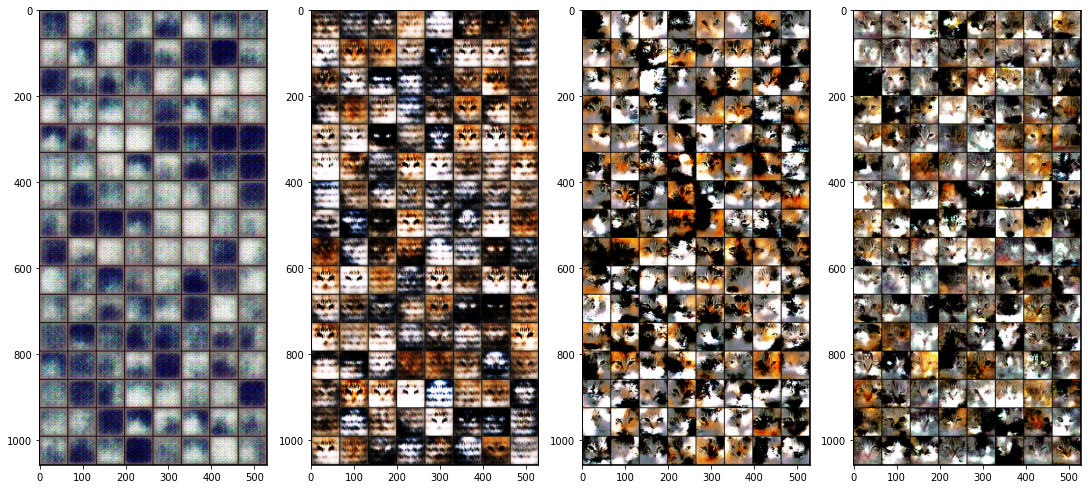

In [56]:
fig, [ax0, ax1, ax2, ax3] = plt.subplots(nrows = 1,ncols = 4, figsize=(15,15), constrained_layout=True)
img0 = io.read_file('./image-0001.png')
img0 = image.decode_png(img0, channels=3)
img5 = io.read_file('./image-0005.png')
img5 = image.decode_png(img5, channels=3)
img100 = io.read_file('./image-0100.png')
img100 = image.decode_png(img100, channels=3)
img200 = io.read_file('./image-0200.png')
img200 = image.decode_png(img200, channels=3)
ax0.imshow(img0)
ax1.imshow(img5)
ax2.imshow(img100)
ax3.imshow(img200);